# Facial Emotion Recogination

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## importing libraries

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf

In [3]:
!pwd

/Users/aman/Project/MRFEA-code


In [4]:

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import zipfile


# **Let's Use Internal GPU if there's any available**

In [5]:
!pip3 install wandb

In [6]:
!wandb login --relogin d1bef696e6b253e223b885d9a44c844d59c37c1c

wandb: Appending key for api.wandb.ai to your netrc file: /Users/aman/.netrc


In [7]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="musicreco", entity="developer1404")

wandb: Currently logged in as: developer1404 (use `wandb login --relogin` to force relogin)


In [8]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.7.0


In [9]:
# path_to_zip_file = "/Users/aman/Project/MRFEA-code/archive.zip"
# directory_to_extract_to = "FER_data"

In [10]:
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [11]:
!rm -rf "archive/train/disgust"
!rm -rf "archive/test/disgust"
!rm -rf "archive/train/fear"
!rm -rf "archive/test/fear"
!rm -rf "archive/train/surprise"
!rm -rf "archive/test/surprise"
!find . -name '.DS_Store' -type f -delete
!find . -name '__MACOSX' -type f -delete

In [12]:
basedir = "/Users/aman/Project/MRFEA-code/archive"

train_dir = os.path.join(basedir,'train/')
test_dir = os.path.join(basedir,'test/')

row, col = 48, 48
classes = 4

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy   sad  neutral  angry
train   7215  4830     4965   3995
      happy   sad  neutral  angry
test   1774  1247     1233    958


### PLot of number of images in training set

In [13]:
train_count

,happy,sad,neutral,angry
train,7215,4830,4965,3995


/Users/aman/Project/tensorflow-test/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

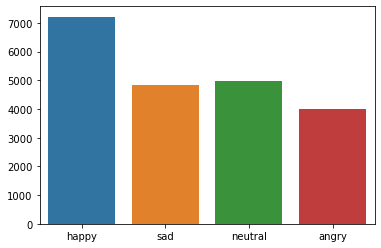

In [14]:
sns.barplot(train_count.columns, train_count.values[0])

/Users/aman/Project/tensorflow-test/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

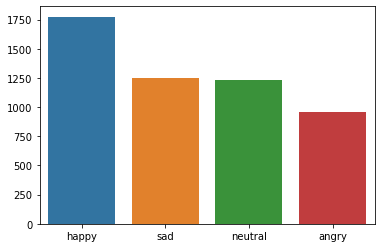

In [15]:
sns.barplot(test_count.columns, test_count.values[0])

### PLot of number of images in test set

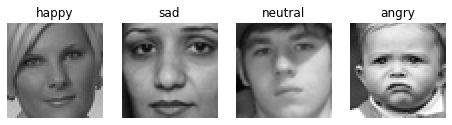

In [16]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [17]:
image_size= 48
batch_size= 64
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range = 0.30)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


In [18]:
def auroc(y_true, y_pred):
    return np.py_func(roc_auc_score, (y_true, y_pred), tf.double)

## Defining Model

In [19]:
import keras

In [20]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras import models
from keras import layers

classes = 4
def model():
  # load model without classifier layers
  pretrained = VGG16(include_top=False, weights = "imagenet", input_shape=(48, 48, 3))
  # add new classifier layers
  flat1 = Flatten()(pretrained.layers[-1].output)
  denseout1 = Dense(1024, activation='relu')(flat1)
  denseout2 = Dense(512, activation='relu')(denseout1)
  output = Dense(classes, activation='softmax')(denseout2)
  # define new model
  model = Model(inputs=pretrained.inputs, outputs=output)
  opt = Adam(learning_rate=0.0001 , decay=1e-7)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["acc"])
  # summarize
  return model

In [21]:
import wandb

In [22]:
# Initialize wandb with your project name
run = wandb.init(project='musicreco', entity='developer1404',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 16,
                     "batch_size": 64, 
                     "loss_function": "categorical_crossentropy", 
                     "architecture": "CNN",
                     "dataset": "FER_data"
                 })

config = wandb.config  # We'll use this to configure our experiment

In [23]:
model = model()
model.summary()

2021-12-11 18:08:57.841566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-11 18:08:57.841686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 21.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                             

### Callbacks Function

In [24]:
from wandb.keras import WandbCallback

chk_path = 'model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=10, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger, earlystop,WandbCallback()] 

## Training Model

In [25]:
from sklearn.utils import class_weight

In [26]:
test_count

,happy,sad,neutral,angry
test,1774,1247,1233,958


In [27]:
y = []
for col in train_count.columns:
  y.extend([col]*train_count[col]["train"])

In [28]:
np.unique(y)

array(['angry', 'happy', 'neutral', 'sad'], dtype='<U7')

In [29]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y),
                                                  y = y)

In [30]:
class_weights = dict(enumerate(class_weights))

In [31]:
class_weights

# {0: 1.3123282538096428,
#  1: 0.7281011781011781,
#  2: 1.0580563947633435,
#  3: 1.0876293995859214}

{0: 1.3144555694618272,
 1: 0.7278239778239778,
 2: 1.0576535750251763,
 3: 1.0872153209109732}

In [32]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

In [33]:
model.layers[-10:][0].trainable

True

In [34]:
hist = model.fit(x=training_set,
                 validation_data = test_set,
                 class_weight = class_weights,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

2021-12-11 18:08:58.557509: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/60


2021-12-11 18:08:58.857318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - ETA: 0s - loss: 1.0980 - acc: 0.5254

2021-12-11 18:09:18.733787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.86709, saving model to model.h5
328/328 [==============================] - 22s 65ms/step - loss: 1.0980 - acc: 0.5254 - val_loss: 0.8671 - val_acc: 0.6294 - lr: 1.0000e-04
Epoch 2/60
328/328 [==============================] - ETA: 0s - loss: 0.8563 - acc: 0.6678
Epoch 00002: val_loss improved from 0.86709 to 0.76983, saving model to model.h5
328/328 [==============================] - 21s 62ms/step - loss: 0.8563 - acc: 0.6678 - val_loss: 0.7698 - val_acc: 0.6821 - lr: 1.0000e-04
Epoch 3/60
328/328 [==============================] - ETA: 0s - loss: 0.7745 - acc: 0.7041
Epoch 00003: val_loss improved from 0.76983 to 0.74165, saving model to model.h5
328/328 [==============================] - 21s 65ms/step - loss: 0.7745 - acc: 0.7041 - val_loss: 0.7416 - val_acc: 0.6944 - lr: 1.0000e-04
Epoch 4/60
328/328 [==============================] - ETA: 0s - loss: 0.7112 - acc: 0.7344
Epoch 00004: val_loss improved from 0.74165 to 0.73235, saving mode

In [35]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

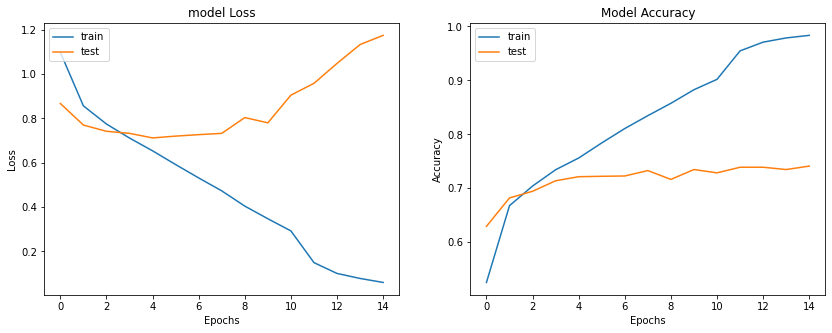

In [36]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model evaluation

In [37]:
def model_data(model):
    train_loss, train_accu = model.evaluate(training_set)
    test_loss, test_accu = model.evaluate(test_set)
    return print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [38]:
model_data(model)

82/82 [==============================] - 2s 18ms/step - loss: 0.7105 - acc: 0.7222
final train accuracy = 79.45 , validation accuracy = 72.22


In [39]:
model.save_weights('final_weight.h5')

### Confusion Matrix and Classification on training set

In [40]:
model.load_weights("model.h5")

In [41]:
image_size= 48
batch_size= 64
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range = 0.30)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=False,
                                                color_mode='rgb',
                                                class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=False,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


In [42]:
y_pred = model.predict(training_set)


2021-12-11 18:14:17.962966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [43]:
test_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

Confusion Matrix
[[3182   87  439  287]
 [ 162 6393  607   53]
 [ 286  178 3973  528]
 [ 605  140  905 3180]]
Classification Report
              precision    recall  f1-score   support

       angry       0.75      0.80      0.77      3995
       happy       0.94      0.89      0.91      7215
     neutral       0.67      0.80      0.73      4965
         sad       0.79      0.66      0.72      4830

    accuracy                           0.80     21005
   macro avg       0.79      0.79      0.78     21005
weighted avg       0.81      0.80      0.80     21005



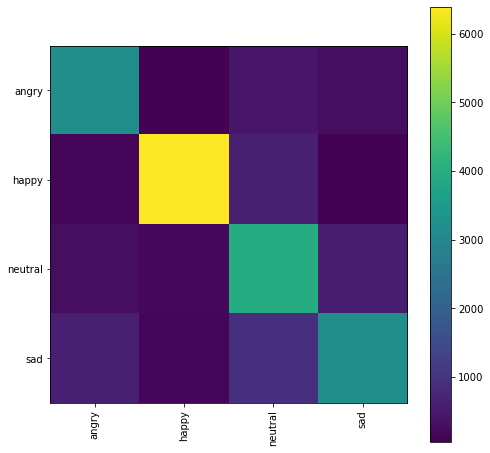

In [44]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
# print(roc_auc_score(training_set.classes, y_pred))

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

In [45]:
y_pred = model.predict(test_set)

In [46]:
y_pred

array([[0.94534355, 0.02200171, 0.00400012, 0.02865467],
       [0.8965067 , 0.02969099, 0.02385886, 0.04994348],
       [0.03354139, 0.00437105, 0.02002922, 0.9420584 ],
       ...,
       [0.05427552, 0.00924007, 0.83701485, 0.09946958],
       [0.01545079, 0.6335481 , 0.19668965, 0.15431145],
       [0.24365292, 0.00272753, 0.03505842, 0.7185611 ]], dtype=float32)

In [47]:
y_pred

array([[0.94534355, 0.02200171, 0.00400012, 0.02865467],
       [0.8965067 , 0.02969099, 0.02385886, 0.04994348],
       [0.03354139, 0.00437105, 0.02002922, 0.9420584 ],
       ...,
       [0.05427552, 0.00924007, 0.83701485, 0.09946958],
       [0.01545079, 0.6335481 , 0.19668965, 0.15431145],
       [0.24365292, 0.00272753, 0.03505842, 0.7185611 ]], dtype=float32)

Confusion Matrix
[[ 676   46  127  109]
 [  65 1508  179   22]
 [ 106   45  915  167]
 [ 225   82  275  665]]
Classification Report
              precision    recall  f1-score   support

       angry       0.63      0.71      0.67       958
       happy       0.90      0.85      0.87      1774
     neutral       0.61      0.74      0.67      1233
         sad       0.69      0.53      0.60      1247

    accuracy                           0.72      5212
   macro avg       0.71      0.71      0.70      5212
weighted avg       0.73      0.72      0.72      5212



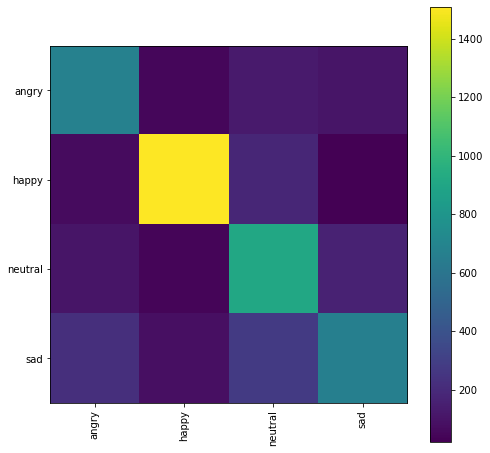

In [48]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis = 1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)